In [377]:
import os, time, cv2, math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
from skimage.morphology import disk
from skimage.filters import median

In [378]:
home_dir = os.path.abspath("") + os.sep

files = { 'before': { 'filename': 'C3S Balken links xyz-Daten Konfokalmessung.asc', 'clip_min':-25000, 'clip_max':15000},
		  'after': { 'filename': 'C3S-Balken z-Daten_nachher.asc', 'clip_min':-25000, 'clip_max':15000} }

In [379]:
def load_file( file ):
	print( "loading 'C3S-Balken {}'".format( file['filename'] ) )

	with open( home_dir + os.sep + file['filename'] ) as f_handle:
		for x in range(15):
			line = next(f_handle)
			if line.__contains__(' = '):
				d = line.split(' = ', 1)
				if   d[0].__contains__('z-unit'):	file['unit']	 = d[1].replace('[', '').replace(']', '').replace('\n', '')
				elif d[0].__contains__('x-pixels'):	file['x-pixels'] = int(d[1])
				elif d[0].__contains__('y-pixels'):	file['y-pixels'] = int(d[1])
				elif d[0].__contains__('x-length'):	file['x-length'] = int(d[1])
		file['scale'] = file['x-length']/file['x-pixels']
		
	file['data']	= np.flipud( np.loadtxt( home_dir + os.sep + file['filename'], delimiter="\t", dtype=str ) ) # for some reason, the dataset is flipped
	file['data']	= file['data'][0:file['y-pixels'],0:file['x-pixels']].astype(np.float64)
	file['min']		= np.min( file['data'])
	file['max']		= np.max( file['data'])
	file['mean']	= np.mean(file['data'])
	#file['data']	= np.clip(file['data'], file['clip_min'], file['clip_max'])

	# get a thumbnail in 8 bit
	resize_factor = 1
	file['thumb']	= cv2.resize(np.clip(file['data'], file['clip_min'], file['clip_max']),(int(file['x-pixels']/resize_factor), int(file['y-pixels']/resize_factor)),interpolation=cv2.INTER_AREA)
	file['thumb']	= cv2.normalize( (file['thumb']+(file['thumb'].min()*-1)), None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

	print( 'x/y-scale: {:.3f} {}/px'.format(file['scale'], file['unit']) )
	print( 'dataset size: {:.1f} x {:.1f} {}'.format( file['x-pixels']*file['scale'], file['y-pixels']*file['scale'], file['unit'] ) )
	print('Min: {}, Max: {}, Mean: {:.6f}'.format( int(file['min']), int(file['max']), file['mean'] ))

	ticks_f, labels_f = get_ticks_in_mm( file['scale'], distance=1, low_label_limit=0, high_limit=20 )

	plt.figure(figsize = (15,5))
	plt.title(file['filename'])
	plt.imshow( np.rot90(file['thumb']), cmap='gray' )
	ticks, labels = filter_label( ticks_f, labels_f, file['y-pixels'] )
	plt.xticks(ticks, labels)
	plt.xlabel('[mm]')
	ticks, labels = filter_label( ticks_f, labels_f, file['x-pixels'] )
	plt.yticks(ticks, labels)
	plt.ylabel('[mm]')
	plt.show()

	print( ticks, labels )

	plt.figure(figsize = (15,3))
	plt.hist(file['data'].flatten(), bins=255) #, figsize=[30,5]
	plt.title("Histogram ({}) in [{}]".format(file['filename'], file['unit']))
	plt.show()

	cv2.imwrite( home_dir + os.sep + file['filename'] + '.tif', (file['data']+(file['min']*-1)).astype(np.uint16) )

	return file

def get_ticks_in_mm( factor_nm_per_px, distance=1, low_label_limit=0, high_limit=100 ):
	ticks  = []
	labels = []
	for n in range(low_label_limit, high_limit+1, distance):
		labels.append(n)#*1000*1000
		ticks.append(n*1000*1000/factor_nm_per_px)

	return ticks, labels

def filter_label( ticks, labels, max_width ):
	ticks_filtered  = []
	labels_filtered = []
	for i, t in enumerate(ticks):
		if t <= max_width:
			ticks_filtered.append(t)#*1000*1000
			labels_filtered.append(labels[i])

	return ticks_filtered, labels_filtered

def align_images(img1, img2):
	sift = cv2.SIFT_create()
	#  detect SIFT features in both images
	keypoints_1, descriptors_1 = sift.detectAndCompute(cv2.GaussianBlur(img1, (7, 7), 0),None)
	keypoints_2, descriptors_2 = sift.detectAndCompute(cv2.GaussianBlur(img2, (7, 7), 0),None)

	FLANN_INDEX_KDTREE = 0
	index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
	search_params = dict(checks = 50)

	flann = cv2.FlannBasedMatcher(index_params, search_params)

	matches = flann.knnMatch(descriptors_1,descriptors_2,k=2)

	good = []
	for m,n in matches:
		if m.distance < 0.4*n.distance: #modify factor 0.2 to improve or worsen the good matches
			good.append(m)
	matches = good
	print(len(matches))

	# draw first 50 matches
	matched_img = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches, img2, flags=2)

	plt.figure(figsize = (10,5))
	plt.title("visualized matches")
	plt.imshow( np.rot90(matched_img), cmap='gray' )
	plt.show()

	# allocate memory for the keypoints (x, y)-coordinates from the
	# top matches -- we'll use these coordinates to compute our
	# homography matrix
	ptsA = np.zeros((len(matches), 2), dtype="float")
	ptsB = np.zeros((len(matches), 2), dtype="float")
	# loop over the top matches
	for (i, m) in enumerate(matches):
		# indicate that the two keypoints in the respective images
		# map to each other
		ptsA[i] = keypoints_1[m.queryIdx].pt
		ptsB[i] = keypoints_2[m.trainIdx].pt

	# compute the homography matrix between the two sets of matched
	# points
	(H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=1 )
	# use the homography matrix to align the images
	(h, w) = img1.shape[:2]

	return H, cv2.warpPerspective(img1, H, (w, h))


In [380]:
def get_value_at_point( img, p=(0,0) ):
	p = (p[0], p[1], img[p[0],p[1]])
	print( 'new point',p )
	return p

def get_mean_value_At_point( img, p=(0,0), buffer=5 ):
	area = img[p[0]-buffer:p[0]+buffer,p[1]-buffer:p[1]+buffer]
	p = (p[0], p[1], area.mean())
	print( 'new point',p,'std dev:', area.std() )
	return p

#https://gist.github.com/ryanbranch/8aa3f0768c6cb9268296468d63f8f21c
def computeBestFitPlane(points):
    valType = np.float64
    
    n = points.shape[0]  # n: the integer number of (X, Y, Z) coordinate triples in points
    if n < 3:
        return None
    
    # Determination of (X, Y, Z) coordinates of centroid ("average" point along each axis in dataset)
    sum = np.zeros((3), dtype=valType)
    for p in points:
        sum += p
    centroid = sum * (1.0 / valType(n))
    
    # Uses Emil Ernerfeldt's technique to calculate the full 3x3 covariance matrix, excluding symmetries
    xx = 0.0
    xy = 0.0
    xz = 0.0
    yy = 0.0
    yz = 0.0
    zz = 0.0
    for p in points:
        r = p - centroid
        xx += r[0] * r[0]
        xy += r[0] * r[1]
        xz += r[0] * r[2]
        yy += r[1] * r[1]
        yz += r[1] * r[2]
        zz += r[2] * r[2]
    xx /= valType(n)
    xy /= valType(n)
    xz /= valType(n)
    yy /= valType(n)
    yz /= valType(n)
    zz /= valType(n)
    
    weighted_dir = np.zeros((3), dtype=valType)
    axis_dir = np.zeros((3), dtype=valType)
    
    # X COMPONENT
    det_x = (yy * zz) - (yz * yz)
    axis_dir[0] = det_x
    axis_dir[1] = (xz * yz) - (xy * zz)
    axis_dir[2] = (xy * yz) - (xz * yy)
    weight = det_x * det_x
    if np.dot(weighted_dir, axis_dir) < 0.0:
        weight *= -1.0
    weighted_dir += axis_dir * weight
    
    # Y COMPONENT
    det_y = (xx * zz) - (xz * xz)
    axis_dir[0] = (xz * yz) - (xy * zz)
    axis_dir[1] = det_y
    axis_dir[2] = (xy * xz) - (yz * xx)
    weight = det_y * det_y
    if np.dot(weighted_dir, axis_dir) < 0.0:
        weight *= -1.0
    weighted_dir += axis_dir * weight
    
    # Z COMPONENT
    det_z = (xx * yy) - (xy * xy)
    axis_dir[0] = (xy * yz) - (xz * yy)
    axis_dir[1] = (xy * xz) - (yz * xx)
    axis_dir[2] = det_z
    weight = det_z * det_z
    if np.dot(weighted_dir, axis_dir) < 0.0:
        weight *= -1.0
    weighted_dir += axis_dir * weight
    
    a = weighted_dir[0]
    b = weighted_dir[1]
    c = weighted_dir[2]
    d = np.dot(weighted_dir, centroid) * -1.0  # Multiplication by -1 preserves the sign (+) of D on the LHS
    normalizationFactor = math.sqrt((a * a) + (b * b) + (c * c))
    if normalizationFactor == 0:
        return None
    elif normalizationFactor != 1.0:  # Skips normalization if already normalized
        a /= normalizationFactor
        b /= normalizationFactor
        c /= normalizationFactor
        d /= normalizationFactor
    # Returns a float 4-tuple of the A/B/C/D coefficients such that (Ax + By + Cz + D == 0)
    return (a, b, c, d)

# https://stackoverflow.com/questions/53698635/how-to-define-a-plane-with-3-points-and-plot-it-in-3d
def get_plane( difference, p0, p1, p2, buffer = 5 ):
	p0 = get_mean_value_At_point( difference, p0, buffer )
	p1 = get_mean_value_At_point( difference, p1, buffer )
	p2 = get_mean_value_At_point( difference, p2, buffer )

	x0, y0, z0 = p0
	x1, y1, z1 = p1
	x2, y2, z2 = p2

	points = [p0,p1 ,p2 ]

	ux, uy, uz = [x1-x0, y1-y0, z1-z0]
	vx, vy, vz = [x2-x0, y2-y0, z2-z0]

	u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

	point  = np.array(p0)
	normal = np.array(u_cross_v)

	d = -point.dot(normal)
	
	xx, yy = np.meshgrid(range(difference.shape[0]), range(difference.shape[1]))

	print(normal[0], normal[1], normal[2], d)
	z = np.array( (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2] )

	# plot the surface	
	plt3d = plt.figure(figsize = (10,4))
	plt.title("background 3-point plane orientation")
	ax = plt3d.add_subplot(projection='3d')
	ax.plot_surface(xx, yy, z)
	ax.plot(x0, y0, z0, marker='o', color="red")
	ax.plot(x1, y1, z1, marker='o', color="red")
	ax.plot(x2, y2, z2, marker='o', color="red")
	plt.show()

	plt.figure(figsize = (20,7))
	plt.title("calculated 3-point background plane")
	plt.imshow( z )#, cmap='gray' 
	plt.plot( x0, y0, marker='o', color="red" )
	plt.plot( x1, y1, marker='o', color="red" )
	plt.plot( x2, y2, marker='o', color="red" )
	plt.show()

	z = np.rot90(z)

	return z, points

def get_multipoint_plane( difference, points2d ):
    
    points = np.empty([len(points2d), 3])
    for i, p in enumerate(points2d):
        points[i] = get_mean_value_At_point( difference, p, 5 ) #get_value_at_point( difference, p )
        
    (a,b,c,d) = computeBestFitPlane(points)
    print( a,b,c,d )

    X,Y = np.meshgrid(range(difference.shape[0]), range(difference.shape[1]))
    Z = (- a*X - b*Y - d) / c


    plt3d = plt.figure(figsize = (10,4))
    plt.title("background multipoint plane orientation")
    ax = plt3d.add_subplot(projection='3d')
    ax.plot_surface(X, Y, Z)
    for p in points:
        ax.plot(p[0], p[1], p[2], marker='o', color="red")
    plt.show()

    #plt.figure(figsize = (20,7))
    #plt.title("calculated multipoint background plane")
    #plt.imshow( Z )#, cmap='gray' 
    #for p in points:
    #    plt.plot(p[0], p[1], marker='o', color="red")
    #plt.show()
        
    Z = np.rot90(Z)
    
    return Z, points

loading 'C3S-Balken C3S Balken links xyz-Daten Konfokalmessung.asc'
x/y-scale: 1289.476 nm/px
dataset size: 3177270.0 x 18244802.4 nm
Min: -168136, Max: 14078, Mean: -5.598693


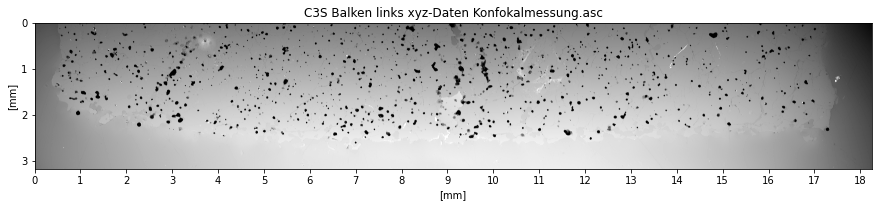

[0.0, 775.5085340559663, 1551.0170681119325, 2326.525602167899] [0, 1, 2, 3]


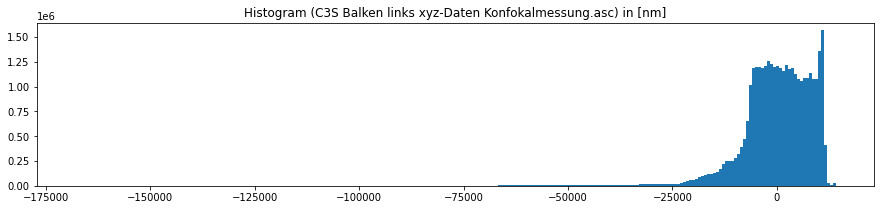

In [381]:
files['before'] = load_file(files['before'])

loading 'C3S-Balken C3S-Balken z-Daten_nachher.asc'
x/y-scale: 1289.477 nm/px
dataset size: 3178560.0 x 18244805.5 nm
Min: -125275, Max: 54998, Mean: 0.004057


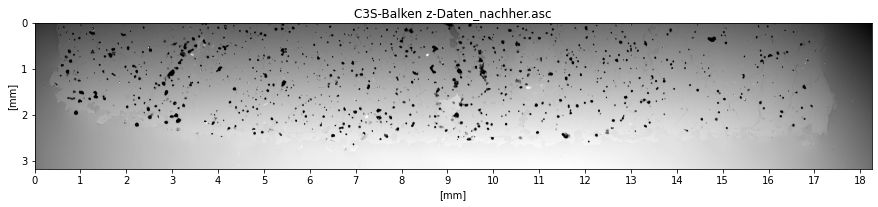

[0.0, 775.5084063223597, 1551.0168126447195, 2326.525218967079] [0, 1, 2, 3]


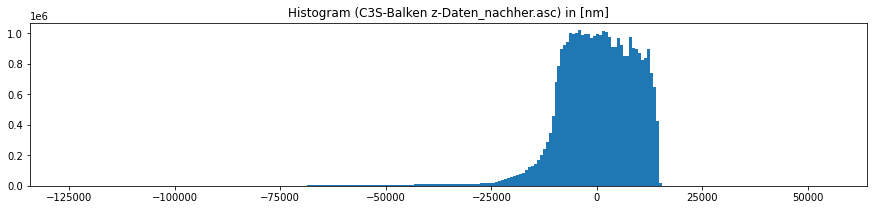

In [382]:
files['after'] = load_file(files['after'])

In [383]:

print(files['before']['data'].shape)

(14149, 2464)


(2500, 2464)


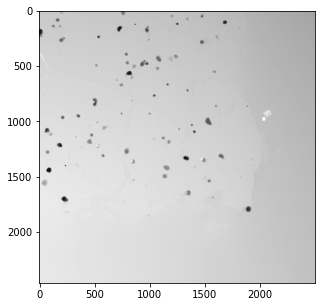

34


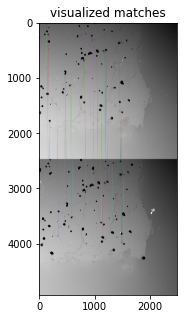

In [384]:
"""
# use if image is loaded without flipping it vertically
x0 = 0000 + 12000
x1 = 2000 + 12000 #full_aligned.shape[0]
"""
x0 = 0000 + 11500
x1 = 2500 + 11500 #full_aligned.shape[0]
# use full height
y0 = 0000
y1 = 2464 #full_aligned.shape[1]

files['before']['thumb'] = files['before']['thumb'][x0:x1,y0:y1]
files['after']['thumb']  = files['after']['thumb'][x0:x1,y0:y1]
files['before']['data']  = files['before']['data'][x0:x1,y0:y1]
files['after']['data']   = files['after']['data'][x0:x1,y0:y1]

print(files['before']['data'].shape)

plt.figure(figsize = (15,5))
plt.imshow( np.rot90(files['before']['data']), cmap='gray' )
plt.show()

H, aligned = align_images(files['before']['thumb'], files['after']['thumb'])
(h, w) = files['before']['data'].shape[:2]
full_aligned = cv2.warpPerspective(files['before']['data'], H, (w, h))


difference = files['after']['data'][0:full_aligned.shape[0],0:full_aligned.shape[1]]-full_aligned[0:full_aligned.shape[0],0:full_aligned.shape[1]]

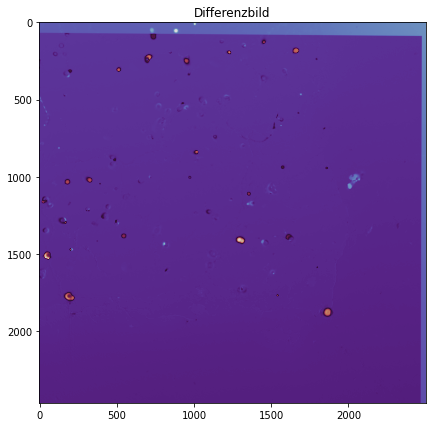

In [385]:
plt.figure(figsize = (20,7))
plt.title("Differenzbild")
plt.imshow( np.rot90(difference), cmap='twilight' )#, cmap='gray'
plt.show()

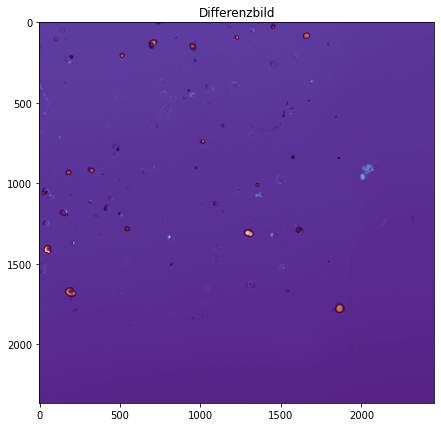

In [386]:
difference   = difference[  0:difference.shape[0]-50,0   : difference.shape[1]-100]
full_aligned = full_aligned[0:full_aligned.shape[0]-50,0 : full_aligned.shape[1]-100]
files['before']['data'] = files['before']['data'][0:files['before']['data'].shape[0]-50,0 : files['before']['data'].shape[1]-100]

plt.figure(figsize = (20,7))
plt.title("Differenzbild")
plt.imshow( np.rot90(difference), cmap='twilight' )#, cmap='gray'
plt.show()

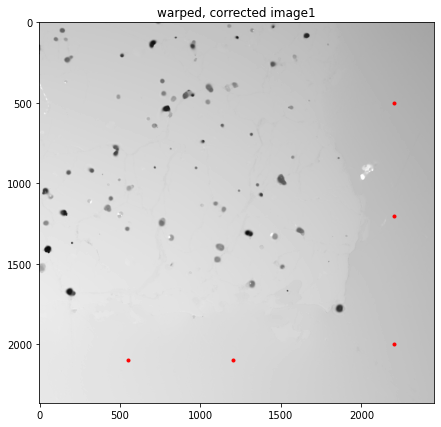

In [387]:
"""
# use if image is loaded without flipping it vertically
p0 = (1850,200)
p1 = (250,2200)
p2 = (1800,2200)
points = np.array( [
	(1850,200),
	(1850,350),
	(1910,550),
	(1900,750),
	(1900,1515),
	(250,2200),
	(1800,2200),
	(500,2300),
	(750,2000),
	(1250,2300),
	(1000,1900),
	(1500,2000),
	(1700,1750),
	(200,1900),
	(900,2200),
	(1800,2400)
] )
"""
points = np.array( [
	#(350, 200),
	#(250, 1550),
	#(1700,1700),
	#(1560,450)
	#(350, 200),
	(550, 2100),
	(1200,2100),
	(2200,2000),
	(2200,1200),
	(2200,500)
] )
p0 = (550, 2100)
p1 = (2200,2000)
p2 = (2200,500)

buffer = 20

plt.figure(figsize = (20,7))
plt.title("warped, corrected image1")
plt.imshow( np.rot90(full_aligned), cmap='gray' )
for p in points:
	plt.plot(p[0], p[1], marker='.', color="red")
plt.show()

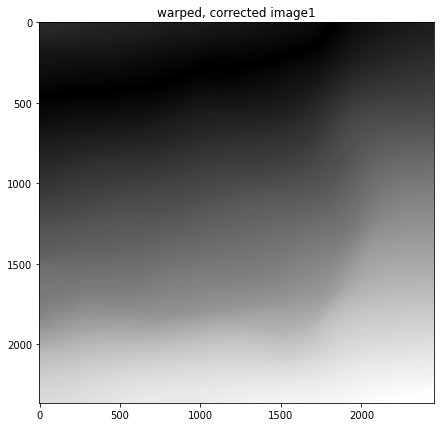

In [388]:
## down sizing
## i don't get, why the x and y diemensions are flipped in the size tuple in cv2.resize()
#median_img = cv2.resize(full_aligned, (int(full_aligned.shape[1]/4), int(full_aligned.shape[0]/4)))
#median_img1 = cv2.resize(files['before']['data'], (int(files['before']['data'].shape[1]/4), int(files['before']['data'].shape[0]/4)))

## mean-processsing
#median_img  = median(median_img,  disk(51))
#median_img1 = median(median_img1, disk(51))
#median_img = median_img1 - median_img

median_img = cv2.resize(difference, (int(difference.shape[1]/4), int(difference.shape[0]/4)))

median_img = median(median_img, disk(51))

# re-upsizing
# i don't get, why the x and y diemensions are flipped in the size tuple in cv2.resize()
#print((full_aligned.shape[0], full_aligned.shape[1]))
median_img = cv2.resize(median_img, (full_aligned.shape[1], full_aligned.shape[0])) #

plt.figure(figsize = (20,7))
plt.title("warped, corrected image1")
plt.imshow( np.rot90(  np.abs(median_img) ), cmap='gray' )
#for p in points:
#	plt.plot(p[0], p[1], marker='.', color="red")
plt.show()

new point (550, 2100, -247.03405681589035) std dev: 18.88242517339838
new point (2200, 2000, 1060.080831577602) std dev: 23.93873842142533
new point (2200, 500, 4239.329967405922) std dev: 22.662730518816453
1642747.4190074068 -5245761.074116727 -2475000.0 9501177884.571726


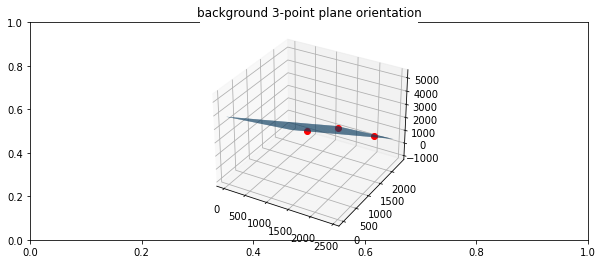

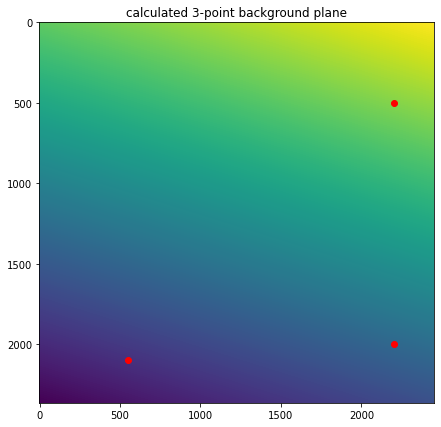

In [389]:
background, points = get_plane(median_img, p0, p1, p2, buffer = buffer )
#background, points = get_multipoint_plane( median_img, points )
#background, points = get_multipoint_plane( difference, points )

#background = median_img # overwrite background-point result

In [390]:
result = files['after']['data'][:background.shape[0],:background.shape[1]]-background

#corrected_difference = full_aligned-result

corrected_difference = difference[:background.shape[0],:background.shape[1]]-background

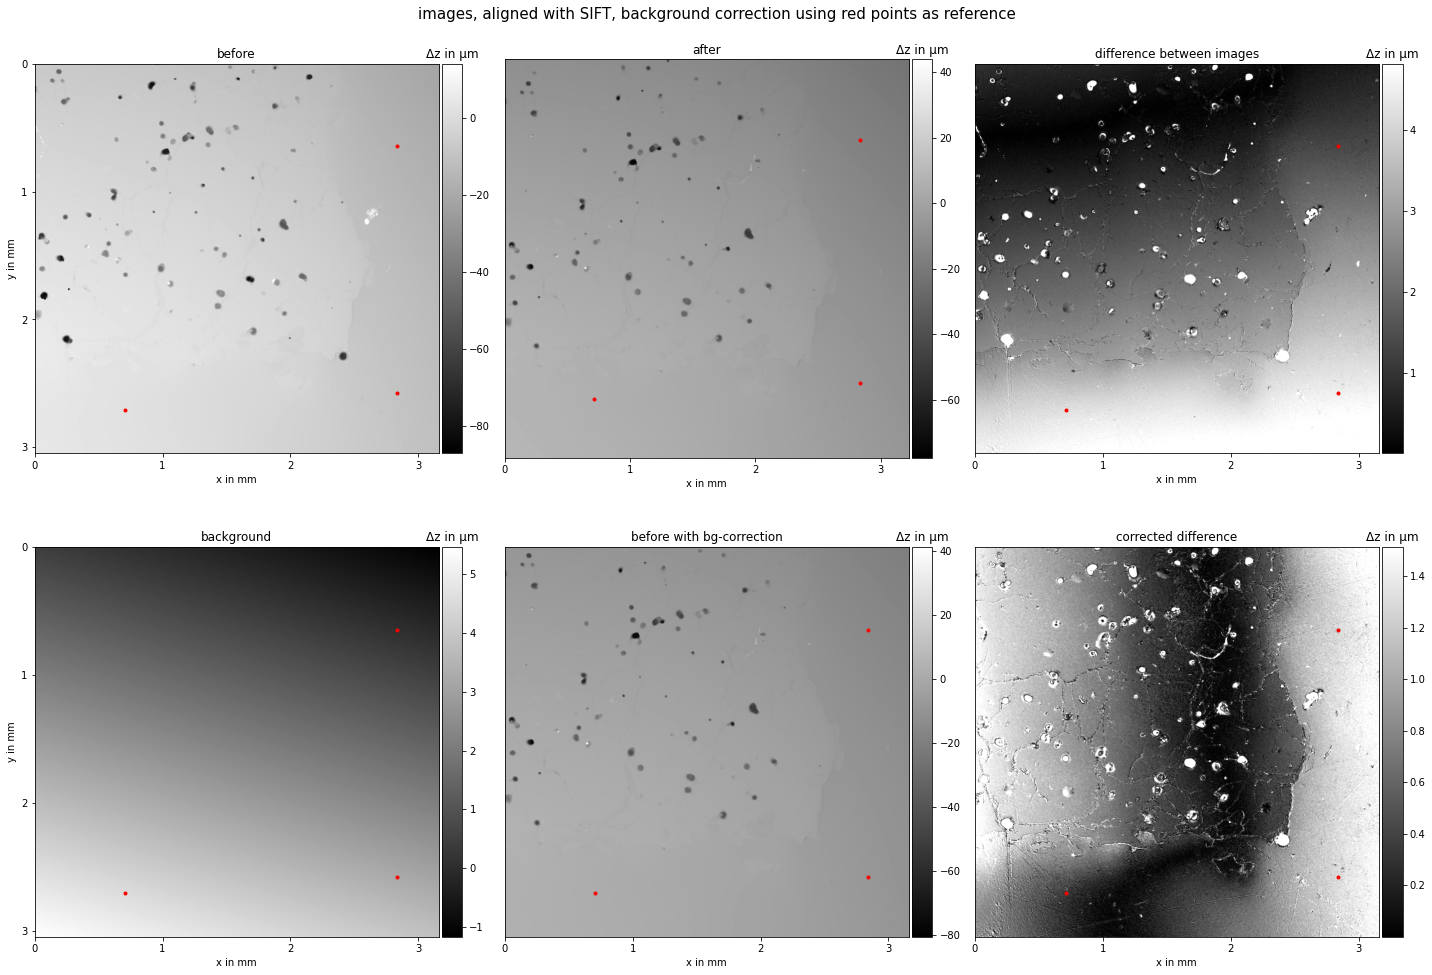

In [391]:
marker_color = "red"
cmap		 = 'gray'

images = {	"before": full_aligned, 
			"after":  files['after']['data'],
			"difference between images": np.abs(difference),
			"background":background, 
			"before with bg-correction": result,
			"corrected difference": np.abs(corrected_difference)
		}
clip = {	"before": [0,100], 
			"after":  [0,100],
			"difference between images": [0,95],
			"background": [0,100], 
			"before with bg-correction": [0,100],
			"corrected difference": [0,95]
		}

	
ticks_f, labels_f = get_ticks_in_mm( files['after']['scale'], distance=1, low_label_limit=0, high_limit=20 )

# Initialise the subplot function using number of rows and columns
fig, axis = plt.subplots(2, int(len(images)/2), figsize = (20,14))
i=0
for title, img in images.items():
	clip_min, clip_max = np.percentile(img, clip[title], method='lower')
	j = 0 if i < int(len(images)/2) else 1
	k = i if i < int(len(images)/2) else i-int(len(images)/2)
	im_show = np.rot90(np.clip(img, clip_min, clip_max)/1000)
	plot = axis[j,k].imshow( im_show, cmap=cmap )#, cmap='gray'

	for p in points:
		axis[j,k].plot(p[0], p[1], marker='.', color=marker_color)

	axis[j,k].set_title(title)
	ticks, labels = filter_label( ticks_f, labels_f, im_show.shape[1] )
	axis[j,k].set_xticks(ticks, labels)
	axis[j,k].set_xlabel('x in mm')
	if ( k == 0 ):
		ticks, labels = filter_label( ticks_f, labels_f, im_show.shape[1] )
		axis[j,k].set_yticks(ticks, labels)
		axis[j,k].set_ylabel('y in mm')
	else: axis[j,k].set_yticks([])

	clb = fig.colorbar(plot, cax=make_axes_locatable(axis[j,k]).append_axes('right', size='5%', pad=0.05), orientation='vertical')
	clb.ax.set_title('Δz in µm')
	#clb.ax.set_ylabel('z in µm')
	i += 1

fig.suptitle("images, aligned with SIFT, background correction using red points as reference", fontsize=15)
plt.tight_layout()
plt.show()

In [392]:
# https://github.com/scikit-image/scikit-image/blob/5da1d5800f53fcdb42202396b9219ce5e0579440/skimage/measure/profile.py#L130-L174
# not aliased!
def line_profile_coordinates(src, dst, linewidth=1):
    src_row, src_col = src = np.asarray(src, dtype=float)
    dst_row, dst_col = dst = np.asarray(dst, dtype=float)
    d_row, d_col = dst - src
    theta = np.arctan2(d_row, d_col)

    length = int(np.ceil(np.hypot(d_row, d_col) + 1))
    # we add one above because we include the last point in the profile
    # (in contrast to standard numpy indexing)
    line_col = np.linspace(src_col, dst_col, length)
    line_row = np.linspace(src_row, dst_row, length)

    # we subtract 1 from linewidth to change from pixel-counting
    # (make this line 3 pixels wide) to point distances (the
    # distance between pixel centers)
    col_width = (linewidth - 1) * np.sin(-theta) / 2
    row_width = (linewidth - 1) * np.cos(theta) / 2
    perp_rows = np.stack([np.linspace(row_i - row_width, row_i + row_width,
                                      linewidth) for row_i in line_row])
    perp_cols = np.stack([np.linspace(col_i - col_width, col_i + col_width,
                                      linewidth) for col_i in line_col])
    # changed output format to 2 1D-arrays containing all x and all y coordinates of the line-pixels 
    return perp_rows.astype(int).flatten(), perp_cols.astype(int).flatten()#np.vstack((perp_rows.astype(int).flatten(), perp_cols.astype(int).flatten())).T


def draw_rect_on_fft_mask( p, mask, width=20, value=0 ):
    rows, cols = mask.shape

    d = int(width/2)

    # set [0,0] coordinate to the center of the fft result
    p = [int(rows/2)+p[0],int(cols/2)+p[1]] 

    # set mask to value at opposing quadrants.
    mask[p[0]-d : p[0]+d, p[1]-d : p[1]+d] = value
    mask[(-p[0])-d : (-p[0])+d, (-p[1])-d : (-p[1])+d] = value

    return mask

def draw_line_on_fft_mask( p1, p2, mask, linewidth=5, value=0 ):
    rows, cols = mask.shape

    # set [0,0] coordinate to the center of the fft result
    p1 = [int(rows/2)+p1[0],int(cols/2)+p1[1]]
    p2 = [int(rows/2)+p2[0],int(cols/2)+p2[1]]

    # set mask to value at opposing quadrants.
    line_cx, line_cy = line_profile_coordinates(p1, p2, linewidth=linewidth)
    mask[line_cx, line_cy] = value
    mask[line_cx*-1, line_cy*-1] = value

    return mask

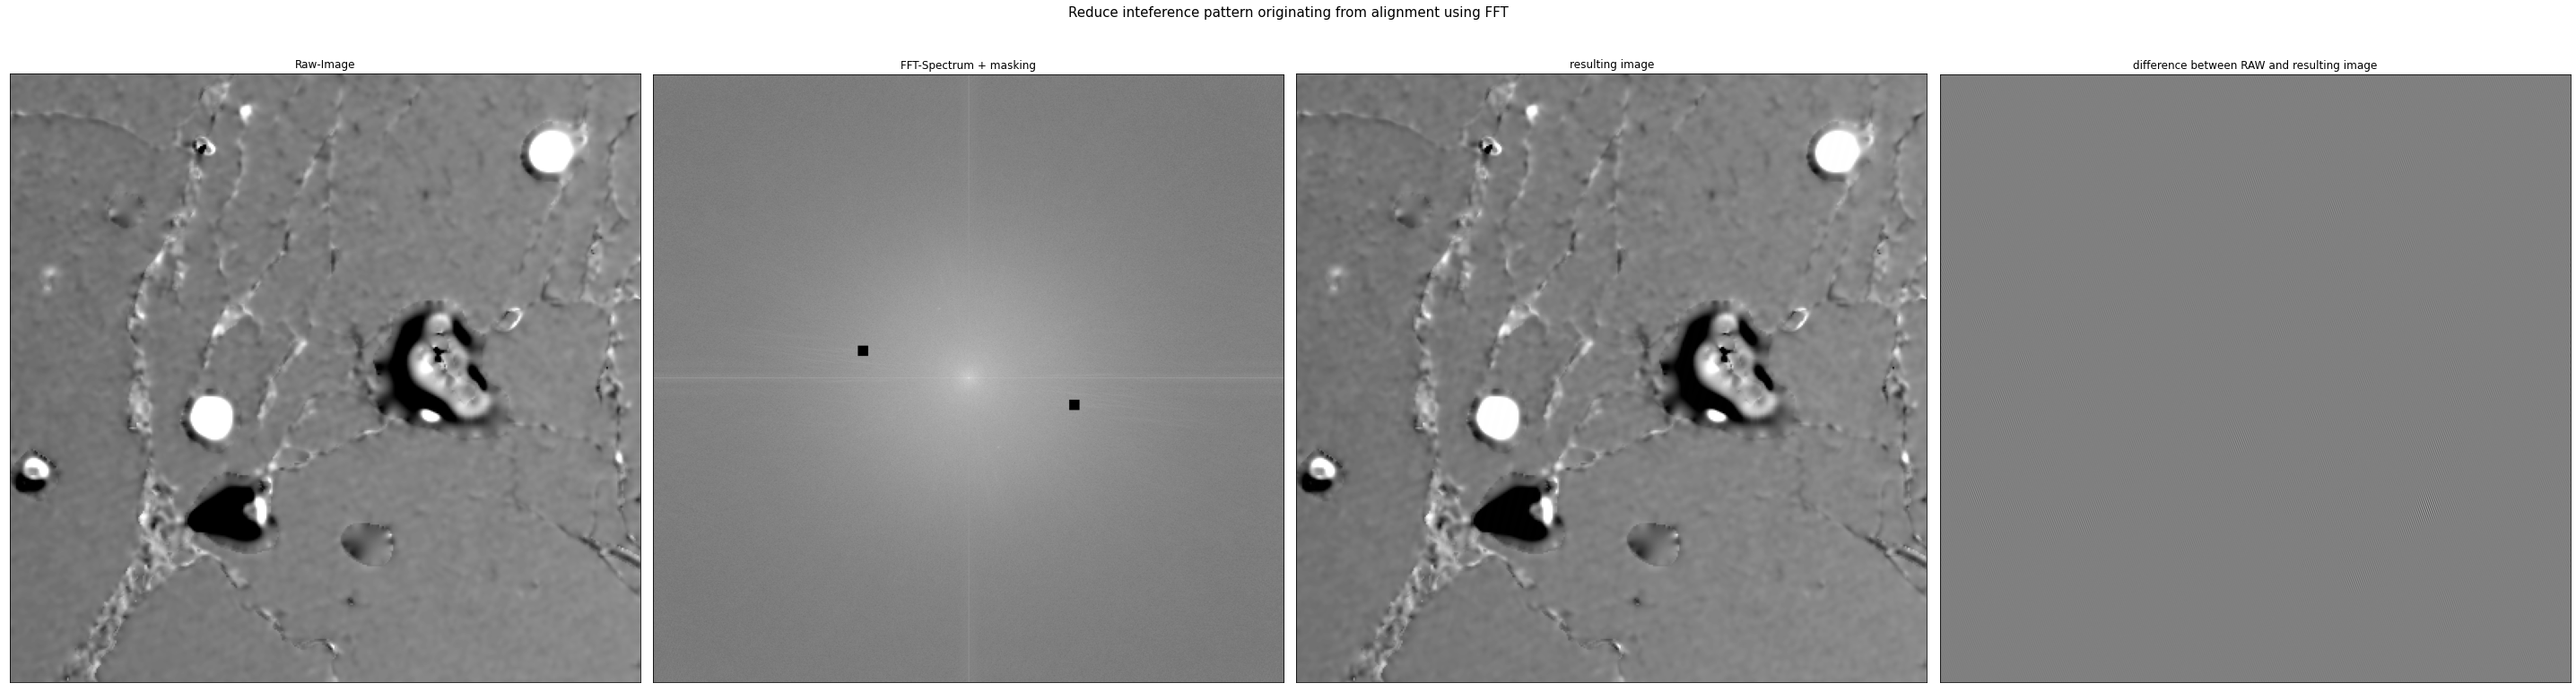

In [393]:
clip_max= 2000

img = np.rot90( np.clip(corrected_difference, -clip_max, clip_max) )
#img = img[int(img.shape[0]*2/6):int(img.shape[0]*3/6), int(img.shape[1]*3/6):int(img.shape[1]*4/6)]

fshift = np.fft.fftshift( np.fft.fft2(img) )
magnitude_spectrum  = 20*np.log(np.abs(fshift))

# try to remove frequencies which appear due to the image alignment
mask = np.ones(img.shape,np.uint8)

"""
# use if image is loaded without flipping it vertically
mask = draw_line_on_fft_mask( [90, -185], [200, -400], mask, linewidth=3 )
#mask = draw_line_on_fft_mask( [200,-30], [500, -90], mask )
mask = draw_rect_on_fft_mask( [285,-95], mask )
mask = draw_rect_on_fft_mask( [115,-350], mask )
"""

#mask = draw_line_on_fft_mask( [-90, -185], [-200, -400], mask, linewidth=3 )
#mask = draw_rect_on_fft_mask( [-285,-135], mask )
mask = draw_rect_on_fft_mask( [-105,-410], mask, width=40 )
#mask = draw_line_on_fft_mask( [-285,-135], [-25, -12], mask, linewidth=2 )#[800, 260]

img_inv_fft = np.real( np.fft.ifft2( np.fft.ifftshift(fshift*mask) ) )

fig = plt.figure(figsize = (40,12),facecolor='white')
plt.subplot(141),plt.imshow( img[int(img.shape[0]*2/6):int(img.shape[0]*3/6), int(img.shape[1]*3/6):int(img.shape[1]*4/6)], cmap = 'gray')
#plt.subplot(131),plt.imshow( img, cmap = 'gray')
plt.title('Raw-Image'), plt.xticks([]), plt.yticks([])
plt.subplot(142),plt.imshow( (magnitude_spectrum*mask), cmap = 'gray')
plt.title('FFT-Spectrum + masking'), plt.xticks([]), plt.yticks([])
plt.subplot(143),plt.imshow( img_inv_fft[int(img.shape[0]*2/6):int(img.shape[0]*3/6), int(img.shape[1]*3/6):int(img.shape[1]*4/6)], cmap = 'gray')
plt.title('resulting image'), plt.xticks([]), plt.yticks([])
plt.subplot(144),plt.imshow( img_inv_fft-img, cmap = 'gray')
plt.title('difference between RAW and resulting image'), plt.xticks([]), plt.yticks([])
plt.tight_layout()
fig.suptitle("Reduce inteference pattern originating from alignment using FFT", fontsize=15)
plt.show()

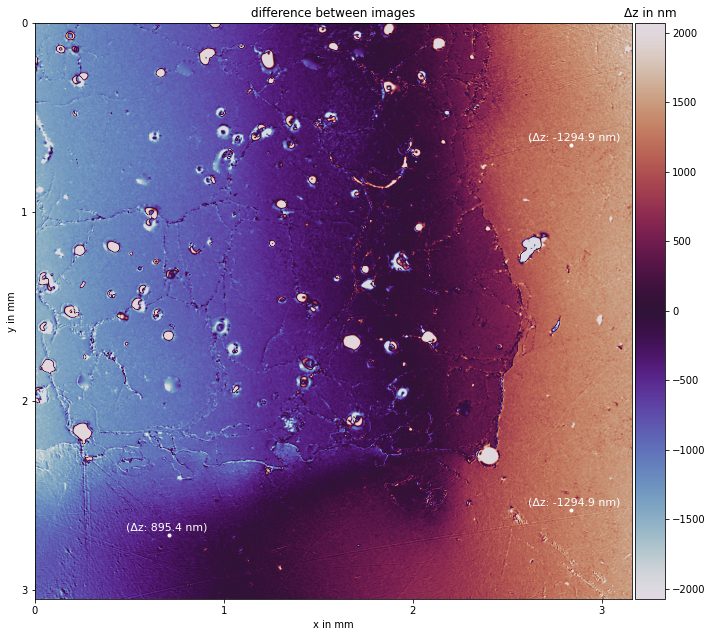

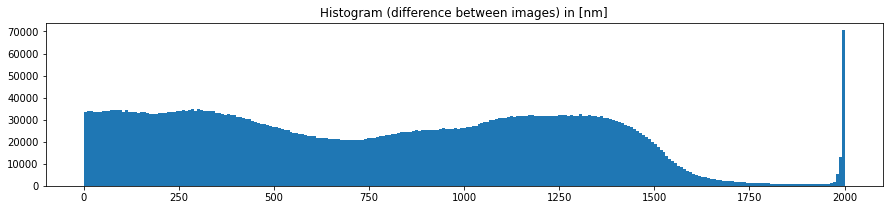

In [394]:
marker_color = "white"

disply_diff = np.clip(np.absolute(img_inv_fft), 0, clip_max)#[500:1000,500:1000]

clip_min, clip_max = np.percentile(img, clip[title], method='lower')
ticks_f, labels_f = get_ticks_in_mm( files['after']['scale'], distance=1, low_label_limit=0, high_limit=20 )

fig, axis = plt.subplots(1,1, figsize = (10,10))
plot = axis.imshow( img_inv_fft, cmap='twilight' )

ticks, labels = filter_label( ticks_f, labels_f, img_inv_fft.shape[0] )
axis.set_xticks(ticks, labels)
axis.set_xlabel('x in mm')

ticks, labels = filter_label( ticks_f, labels_f, img_inv_fft.shape[1] )
axis.set_yticks(ticks, labels)
axis.set_ylabel('y in mm')

for i, p in enumerate(points):
	axis.plot(p[0], p[1], marker='.', color=marker_color)
	delta = background[int(p[0]), int(p[1])]-p[2]
	#txt = '({:.0f} {:.0f} {:.0f} ,d:{:.1f} nm)'.format(p[1], p[0], p[2], delta)
	txt = '(Δz: {:.1f} nm)'.format(delta)
	axis.text(p[0]-175, p[1]-20, txt, fontsize=11, color=marker_color)

axis.set_title("difference between images")
#axis.set_xticks([])
#axis.set_yticks([])

clb = fig.colorbar(plot, cax=make_axes_locatable(axis).append_axes('right', size='5%', pad=0.05), orientation='vertical')
clb.ax.set_title('Δz in nm')

plt.tight_layout()
plt.show()



plt.figure(figsize = (15,3))
plt.hist(np.absolute(disply_diff).flatten(), bins=255) #, figsize=[30,5]
plt.title("Histogram (difference between images) in [{}]".format(files['before']['unit']))
plt.show()

new point (550, 2100, 1223.223789880118) std dev: 79.41994384351729
new point (2200, 2000, 1098.5693896073553) std dev: 73.54343657432904
new point (2200, 500, -308.59500074011476) std dev: 139.27574395232674
-46265.16137439685 2321821.244073326 -2475000.0 -1822899893.8447733


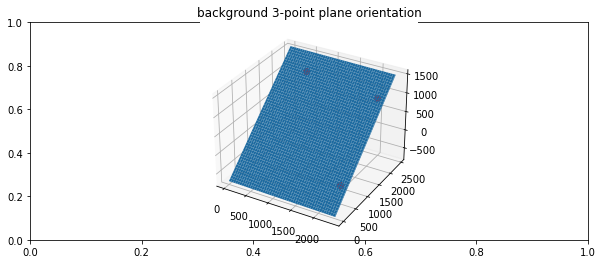

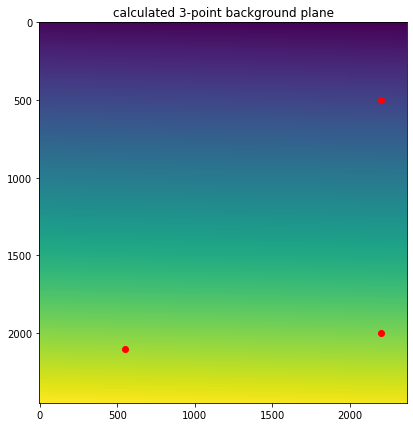

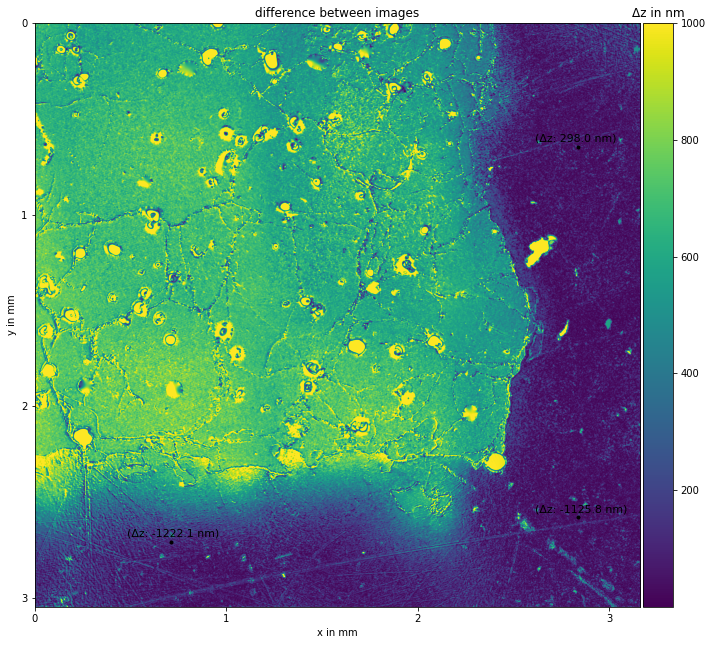

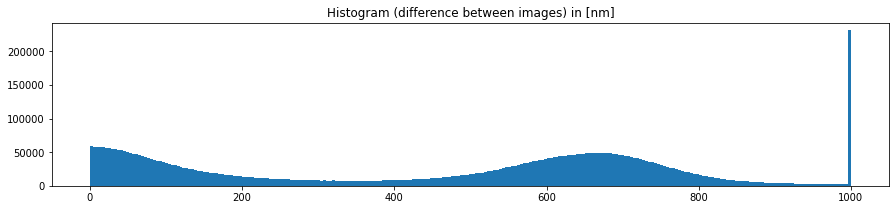

In [395]:
clip_max=  1000

background, points = get_plane(img_inv_fft, points[0],points[1],points[2], buffer = buffer )

img_inv_fft = img_inv_fft-background

marker_color = "black"

disply_diff = np.clip(np.absolute(img_inv_fft), 0, clip_max)#[500:1000,500:1000]

clip_min, clip_max = np.percentile(img_inv_fft, clip[title], method='lower')
ticks_f, labels_f = get_ticks_in_mm( files['after']['scale'], distance=1, low_label_limit=0, high_limit=20 )

fig, axis = plt.subplots(1,1, figsize = (10,10))
plot = axis.imshow( disply_diff)#, cmap='twilight' )

ticks, labels = filter_label( ticks_f, labels_f, img_inv_fft.shape[0] )
axis.set_xticks(ticks, labels)
axis.set_xlabel('x in mm')

ticks, labels = filter_label( ticks_f, labels_f, img_inv_fft.shape[1] )
axis.set_yticks(ticks, labels)
axis.set_ylabel('y in mm')

for i, p in enumerate(points):
	axis.plot(p[0], p[1], marker='.', color=marker_color)
	delta = img_inv_fft[int(p[0]), int(p[1])]-p[2]
	#txt = '({:.0f} {:.0f} {:.0f} ,d:{:.1f} nm)'.format(p[1], p[0], p[2], delta)
	txt = '(Δz: {:.1f} nm)'.format(delta)
	axis.text(p[0]-175, p[1]-20, txt, fontsize=11, color=marker_color)

axis.set_title("difference between images")
#axis.set_xticks([])
#axis.set_yticks([])

clb = fig.colorbar(plot, cax=make_axes_locatable(axis).append_axes('right', size='5%', pad=0.05), orientation='vertical')
clb.ax.set_title('Δz in nm')

plt.tight_layout()
plt.show()



plt.figure(figsize = (15,3))
plt.hist(np.absolute(disply_diff).flatten(), bins=255) #, figsize=[30,5]
plt.title("Histogram (difference between images) in [{}]".format(files['before']['unit']))
plt.show()